<a href="https://colab.research.google.com/github/navidh86/perturbseq-10701/blob/master/nt_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install enformer-pytorch

In [3]:
# ONLY FOR COLAB
# !git clone https://github.com/navidh86/perturbseq-10701.git
# %cd ./perturbseq-10701
# !pip install fastparquet tqdm


In [4]:
# !pip install --upgrade git+https://github.com/huggingface/transformers.git

In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
# from transformers import AutoTokenizer, AutoModelForMaskedLM
from enformer_pytorch import Enformer, seq_indices_to_one_hot

import os
import pickle
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\navid\anaconda3\envs\torchgpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

'cuda'

In [6]:
# Get dataloader
from data.reference_data_alternate import (
    PairPerturbSeqDataset,
    perturbseq_collate,
    get_dataloader
)

train_loader = get_dataloader(type="train", 
                            batch_size=4, 
                            parquet_path="data/tf_gene_expression.parquet",
                            tf_sequences_path="data/tf_sequences.pkl",
                            gene_sequences_path="data/gene_sequences_4000bp.pkl")   # small batch for NT
test_loader  = get_dataloader(type="test", 
                            batch_size=4, 
                            parquet_path="data/tf_gene_expression.parquet",
                            tf_sequences_path="data/tf_sequences.pkl",
                            gene_sequences_path="data/gene_sequences_4000bp.pkl")   # small )

print("Train size:", len(train_loader))
print("Test size: ", len(test_loader))


Train size: 236692
Test size:  59174


In [8]:
# Calc summary stats
import numpy as np
from torch.utils.data import DataLoader

train_dataset = PairPerturbSeqDataset(type="train",
                                      parquet_path="data/tf_gene_expression.parquet",
                            tf_sequences_path="data/tf_sequences.pkl",
                            gene_sequences_path="data/gene_sequences_4000bp.pkl")

loader = DataLoader(train_dataset, batch_size=512, collate_fn=perturbseq_collate)

all_y = []
for _, y in loader:
    all_y.extend(y.numpy())

all_y = np.array(all_y)
mu = all_y.mean()
sigma = all_y.std()

print("mu =", mu)
print("sigma =", sigma)


mu = -0.022736948
sigma = 0.15207927


In [9]:
def weighted_mse_loss(pred, target, mu, sigma, alpha=3.0, threshold=1.0):
    z = (target - mu) / sigma
    weights = torch.where(torch.abs(z) > threshold, alpha, 1.0)
    return (weights * (pred - target) ** 2).mean()

In [10]:
def combined_loss(pred, target, mu, sigma, alpha=0.7, beta=3.0, threshold=1.0):
    """
    Combined MSE + Correlation loss for log fold change predictions.
    
    Args:
        alpha: Weight for MSE (0.7 = 70% MSE, 30% correlation)
        beta: Weight multiplier for large-effect samples
        threshold: Z-score threshold for "large effect"
    """
    # 1. Weighted MSE component
    mse = (pred - target) ** 2
    z = (target - mu) / sigma
    weights = torch.where(torch.abs(z) > threshold, beta, 1.0)
    weighted_mse = (weights * mse).mean()
    
    # 2. Correlation component (inverted to minimize)
    pred_centered = pred - pred.mean()
    target_centered = target - target.mean()
    
    numerator = (pred_centered * target_centered).sum()
    denominator = torch.sqrt((pred_centered ** 2).sum()) * torch.sqrt((target_centered ** 2).sum())
    correlation = numerator / (denominator + 1e-8)
    corr_loss = 1 - correlation
    
    # 3. Combine
    total_loss = alpha * weighted_mse + (1 - alpha) * corr_loss
    
    return total_loss

##NEW

In [11]:
# Replace the encoder classes with Enformer encoder
class EnformerEncoder(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device
        
        # Load pretrained Enformer
        self.model = Enformer.from_pretrained('EleutherAI/enformer-official-rough').to(device)
        self.model.eval()
        
        # Enformer expects sequences of length 196608 (divisible by 128)
        self.target_length = 196608
        
    def _prepare_sequence(self, seq: str):
        """Convert DNA sequence to one-hot encoded tensor."""
        seq = seq.upper().replace('U', 'T')
        
        # Pad or truncate to target length
        if len(seq) < self.target_length:
            # Pad with N (will be ignored)
            seq = seq + 'N' * (self.target_length - len(seq))
        else:
            # Take center region
            start = (len(seq) - self.target_length) // 2
            seq = seq[start:start + self.target_length]
        
        # Convert to indices: A=0, C=1, G=2, T=3, N=4
        seq_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
        indices = torch.tensor([seq_map.get(c, 4) for c in seq], dtype=torch.long)
        
        # One-hot encode (ignore N tokens)
        one_hot = seq_indices_to_one_hot(indices.unsqueeze(0))  # (1, target_length, 4)
        
        return one_hot.to(self.device)
    
    @torch.no_grad()
    def forward(self, seq: str):
        """Encode sequence using Enformer and return mean pooled embedding."""
        one_hot = self._prepare_sequence(seq)
        
        # Get Enformer output
        # Returns dict with 'human' and 'mouse' predictions
        # Each has shape (1, 896, 5313) - 896 bins, 5313 tracks
        output = self.model(one_hot)
        
        # Use human predictions and pool over bins
        human_pred = output['human']  # (1, 896, 5313)
        
        # Mean pool over spatial dimension (896 bins)
        embedding = human_pred.mean(dim=1).squeeze(0)  # (5313,)
        
        return embedding

In [13]:
# encoder_mean = NTEncoderMean(device=device)
# encoder_cls  = NTEncoderCLS(device=device)
# encoder_att  = NTEncoderAttention(device=device)


In [12]:
#Function to Save embeddings
# import pickle
# from tqdm import tqdm

# def cache_tf_embeddings(encoder, tf_seq_dict, save_path="tf_embed_cache.pkl"):
#     cache = {}
#     print("Caching TF embeddings...")
#     for tf_name, seq in tqdm(tf_seq_dict.items()):
#         cache[tf_name] = encoder(seq).cpu()
#     pickle.dump(cache, open(save_path, "wb"))
#     print("Saved TF embedding cache to", save_path)


# def cache_gene_embeddings(encoder, gene_seq_dict, save_path="gene_embed_cache.pkl"):
#     cache = {}
#     print("Caching Gene embeddings...")
#     for gene_name, seq in tqdm(gene_seq_dict.items()):
#         cache[gene_name] = encoder(seq).cpu()
#     pickle.dump(cache, open(save_path, "wb"))
#     print("Saved Gene embedding cache to", save_path)

#Function to Save embeddings


def ensure_dir(path):
    if path != "" and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def cache_tf_embeddings(encoder, tf_seq_dict, save_path="./embeds/tf_embed_cache_nt_cls.pkl"):
    # FIX: ensure the directory of save_path exists
    ensure_dir(os.path.dirname(save_path))

    cache = {}
    print("Caching TF embeddings...")

    for tf_name, seq in tqdm(tf_seq_dict.items()):
        emb = encoder(seq).detach().cpu()
        # if hasattr(emb, "cpu"):
        #     emb = emb.cpu()
        cache[tf_name] = emb

    with open(save_path, "wb") as f:
        pickle.dump(cache, f)

    print(f"Saved TF embedding cache to: {os.path.abspath(save_path)}")


def cache_gene_embeddings(encoder, gene_seq_dict, save_path="./embeds/gene_embed_cache_nt_cls.pkl"):
    # FIX: ensure the directory exists
    ensure_dir(os.path.dirname(save_path))

    cache = {}
    print("Caching gene embeddings...")

    for gene_name, seq in tqdm(gene_seq_dict.items()):
        emb = encoder(seq).detach().cpu()
        # if hasattr(emb, "cpu"):
        #     emb = emb.cpu()
        cache[gene_name] = emb

    with open(save_path, "wb") as f:
        pickle.dump(cache, f)

    print(f"Saved Gene embedding cache to: {os.path.abspath(save_path)}")


In [13]:
# Generate and Save embeddings
# import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"

# Load your sequence dictionaries (the same ones the dataloader uses)
tf_seq_dict = pickle.load(open("data/tf_sequences.pkl", "rb"))
gene_seq_dict = pickle.load(open("data/gene_sequences_4000bp.pkl", "rb"))

# Initialize encoder
# encoder_mean = NTEncoderMean(device=device)
# encoder_cls  = NTEncoderCLS(device=device)
# encoder_att  = NTEncoderAttention(device=device)
encoder_enformer = EnformerEncoder(device=device)


if not os.path.exists("./embeds/tf_enformer_alternate.pkl"):
    cache_tf_embeddings(encoder_enformer, tf_seq_dict, save_path="./embeds/tf_enformer_alternate.pkl")

if not os.path.exists("./embeds/gn_enformer_alternate.pkl"):
    cache_gene_embeddings(encoder_enformer, gene_seq_dict, save_path="./embeds/gn_enformer_alternate.pkl")


In [13]:
# #  Download embeddings
# import shutil
# from google.colab import files

# # Path to your embedding directory
# embed_dir = "./embeds"

# # Output zip file name
# zip_name = "nt_embedding_caches.zip"

# # Create zip
# shutil.make_archive("nt_embedding_caches", 'zip', embed_dir)

# # Download zip
# files.download(zip_name)


In [14]:
# New dataset/dataloader with embeddings
class CachedEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, parquet_path, tf_cache_path, gene_cache_path, type="train", train_fraction=0.8, seed=10701):
        df = pd.read_parquet(parquet_path)

        # load caches
        self.tf_cache = pickle.load(open(tf_cache_path, "rb"))
        self.gene_cache = pickle.load(open(gene_cache_path, "rb"))

        # remove entries missing from cache
        df = df[df["tf_name"].isin(self.tf_cache.keys())]
        df = df[df["gene_name"].isin(self.gene_cache.keys())]

        # shuffle + split
        df = df.sample(frac=1.0, random_state=seed)
        n = int(train_fraction * len(df))
        if type == "train":
            self.df = df.iloc[:n].reset_index(drop=True)
        else:
            self.df = df.iloc[n:].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tf_emb = self.tf_cache[row["tf_name"]]     # tensor
        gene_emb = self.gene_cache[row["gene_name"]]

        # Normalize
        tf_emb = (tf_emb - tf_emb.mean()) / (tf_emb.std() + 1e-8)
        gene_emb = (gene_emb - gene_emb.mean()) / (gene_emb.std() + 1e-8)

        y = torch.tensor(row["expression"], dtype=torch.float32)
        return tf_emb, gene_emb, y


In [15]:
def get_cached_loader(type="train", batch_size=32):
    ds = CachedEmbeddingDataset(
        parquet_path="data/tf_gene_expression.parquet",
        # tf_cache_path="tf_embed_cache.pkl",
        # gene_cache_path="gene_embed_cache.pkl",
        # tf_cache_path="./embeds/tf_attn.pkl",
        # gene_cache_path="./embeds/gn_attn.pkl",
        # tf_cache_path="./embeds/tf_cls.pkl",
        # gene_cache_path="./embeds/gn_cls.pkl",
        tf_cache_path="./embeds/tf_enformer_alternate.pkl",
        gene_cache_path="./embeds/gn_enformer_alternate.pkl",
        type=type
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=(type=="train"))

# def get_cached_loader(type="train", batch_size=32):
#     ds = CachedEmbeddingDataset(
#         parquet_path="tf_gene_expression.parquet",
#         tf_cache_path="./embeds/tf_embed_cache.pkl",
#         gene_cache_path="./embeds/gene_embed_cache.pkl",
#         type=type
#     )
#     return DataLoader(ds, batch_size=batch_size, shuffle=(type=="train"))



In [19]:
# # MLP OLD
# class NTBiEncoderFast(nn.Module):
#     def __init__(self, emb_dim=1280):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(emb_dim * 2, 512),
#             nn.ReLU(),
#             nn.Linear(512, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#     def forward(self, tf_embs, gene_embs):
#         h = torch.cat([tf_embs, gene_embs], dim=-1)
#         return self.mlp(h).squeeze(-1)


In [16]:
# MLP new
class InteractionMLP(nn.Module):
    def __init__(self, emb_dim=1280):
        super().__init__()

        # TF emb (1280) + gene emb (1280) + interaction (1280)
        in_dim = emb_dim * 3

        self.net = nn.Sequential(
            nn.Linear(in_dim, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 128),
            nn.ReLU(),

            nn.Linear(128, 1)
        )

    def forward(self, tf_emb, gene_emb):
        interaction = tf_emb * gene_emb
        h = torch.cat([tf_emb, gene_emb, interaction], dim=-1)
        return self.net(h).squeeze(-1)


In [17]:
# Updated Training Loop
from tqdm import tqdm

def train_one_epoch_cached_enformer(model, loader, optimizer, mu, sigma, device="cuda"):
    model.train()
    total_loss, N = 0.0, 0
    pbar = tqdm(loader)

    for tf_emb, gene_emb, y in pbar:
        tf_emb = tf_emb.to(device)
        gene_emb = gene_emb.to(device)
        y = y.to(device)

        preds = model(tf_emb, gene_emb)
        # loss = weighted_mse_loss(preds, y, mu, sigma)
        loss = combined_loss(preds, y, mu, sigma)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item() * len(y)
        N += len(y)
        pbar.set_postfix({"loss": loss.item()})

    return total_loss / N




In [21]:
train_loader = get_cached_loader(type="train", batch_size=64)
test_loader = get_cached_loader(type="test", batch_size=64)

In [ ]:
TRAIN = False
model_enformer = InteractionMLP(emb_dim=5313).to(device) # for enformer

if TRAIN:
    optimizer = torch.optim.Adam(model_enformer.parameters(), lr=1e-4)

    for epoch in range(10):
        loss = train_one_epoch_cached_enformer(model_enformer, train_loader, optimizer, mu, sigma)
        print("Epoch", epoch, "Loss", loss)
else:
    model_enformer.load_state_dict(torch.load("models/enformer_int_model_alternate.pt"))

100%|██████████| 14794/14794 [09:50<00:00, 25.04it/s, loss=0.408]


Epoch 0 Loss 0.33945057487833497


100%|██████████| 14794/14794 [09:23<00:00, 26.26it/s, loss=0.413]


Epoch 1 Loss 0.3360872585012598


100%|██████████| 14794/14794 [09:20<00:00, 26.38it/s, loss=0.495]


Epoch 2 Loss 0.33441338354305117


100%|██████████| 14794/14794 [08:53<00:00, 27.74it/s, loss=0.651]


Epoch 3 Loss 0.33816792984557403


100%|██████████| 14794/14794 [09:32<00:00, 25.82it/s, loss=0.343]


Epoch 4 Loss 0.342442556116984


100%|██████████| 14794/14794 [09:17<00:00, 26.52it/s, loss=0.429]


Epoch 5 Loss 0.34234483609234095


100%|██████████| 14794/14794 [09:18<00:00, 26.48it/s, loss=0.323]


Epoch 6 Loss 0.34217932482826063


100%|██████████| 14794/14794 [09:34<00:00, 25.74it/s, loss=0.475]


Epoch 7 Loss 0.3424974600975001


100%|██████████| 14794/14794 [08:12<00:00, 30.01it/s, loss=0.24] 


Epoch 8 Loss 0.3423871984147067


100%|██████████| 14794/14794 [08:09<00:00, 30.22it/s, loss=0.36] 

Epoch 9 Loss 0.3424220973366369


In [18]:
def evaluate_enformer_cached(model, loader, mu, sigma, device="cuda"):
    model.eval()
    preds_all, y_all = [], []

    with torch.no_grad():
        for tf_emb, gene_emb, y in loader:
            tf_emb = tf_emb.to(device)
            gene_emb = gene_emb.to(device)
            y = y.to(device)

            preds = model(tf_emb, gene_emb)

            preds_all.append(preds.cpu())
            y_all.append(y.cpu())

    preds_all = torch.cat(preds_all)
    y_all = torch.cat(y_all)

    mse = ((preds_all - y_all)**2).mean().item()
    corr = torch.corrcoef(torch.stack([preds_all, y_all]))[0, 1].item()

    # Large-effect subset
    z = (y_all - mu) / sigma
    mask = torch.abs(z) > 1.0

    if mask.sum() > 0:
        mse_big = ((preds_all[mask] - y_all[mask])**2).mean().item()
        corr_big = torch.corrcoef(torch.stack([preds_all[mask], y_all[mask]]))[0, 1].item()
    else:
        mse_big, corr_big = None, None

    return mse, corr, mse_big, corr_big


In [23]:
mse, corr, mse_big, corr_big = evaluate_enformer_cached(model_enformer, test_loader, mu, sigma, device=device)

print("=== Evaluation Results ===")
print(f"Test MSE:          {mse:.6f}")
print(f"Test Corr:         {corr:.4f}")
print(f"Big-Effect MSE:    {mse_big:.6f}")
print(f"Big-Effect Corr:   {corr_big:.4f}")


=== Evaluation Results ===
Test MSE:          0.020829
Test Corr:         0.0031
Big-Effect MSE:    0.094933
Big-Effect Corr:   0.0036


In [ ]:
# torch.save(model_enformer.state_dict(), "models/enformer_int_model_alternate.pt")
# print("Model saved as enformer_int_model_alternate.pt")


Model saved as enformer_int_model_alternate.pt


In [ ]:
# from google.colab import files
# files.download("nt_cls_int_model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Load the saved model and analyze predictions
import matplotlib.pyplot as plt

# Load the saved model
model_loaded = InteractionMLP(emb_dim=5313).to(device)
model_loaded.load_state_dict(torch.load("models/enformer_int_model_alternate.pt"))
model_loaded.eval()

# Get predictions on test set
preds_list = []
true_list = []

with torch.no_grad():
    for tf_emb, gene_emb, y in test_loader:
        tf_emb = tf_emb.to(device)
        gene_emb = gene_emb.to(device)
        
        preds = model_loaded(tf_emb, gene_emb)
        
        preds_list.append(preds.cpu().numpy())
        true_list.append(y.numpy())

preds_array = np.concatenate(preds_list)
true_array = np.concatenate(true_list)

# Print statistics
print("=== Prediction Analysis ===")
print(f"Predictions - Mean: {preds_array.mean():.6f}, Std: {preds_array.std():.6f}")
print(f"Predictions - Min: {preds_array.min():.6f}, Max: {preds_array.max():.6f}")
print(f"Predictions - Range: {preds_array.max() - preds_array.min():.6f}")
print(f"\nTrue values - Mean: {true_array.mean():.6f}, Std: {true_array.std():.6f}")
print(f"True values - Min: {true_array.min():.6f}, Max: {true_array.max():.6f}")
print(f"True values - Range: {true_array.max() - true_array.min():.6f}")

=== Prediction Analysis ===
Predictions - Mean: -0.021992, Std: 0.000018
Predictions - Min: -0.030914, Max: -0.021778
Predictions - Range: 0.009135

True values - Mean: -0.023525, Std: 0.144314
True values - Min: -1.728746, Max: 13.027078
True values - Range: 14.755824


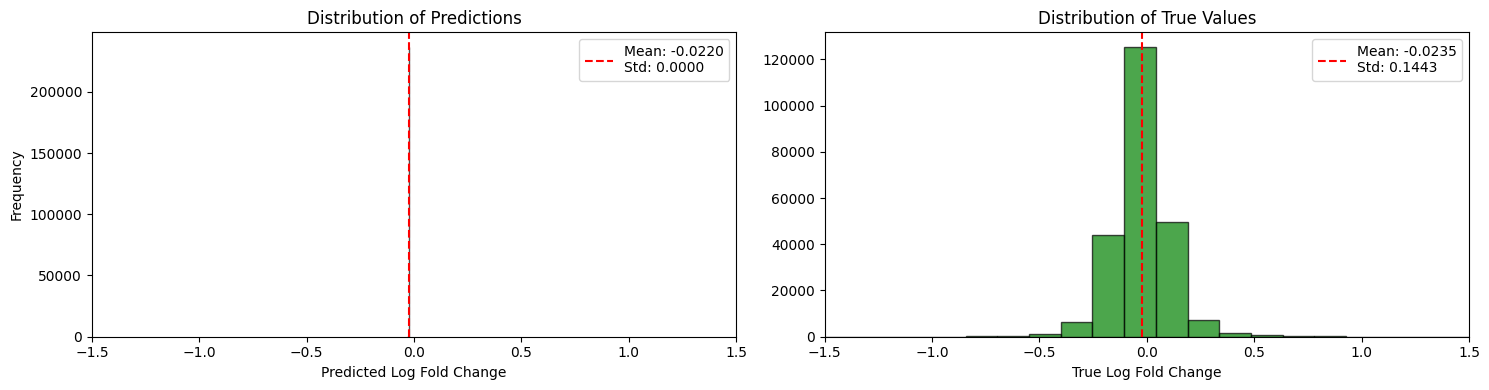


⚠️  WARNING: Model is predicting nearly constant values!
    This indicates the model has collapsed to predicting the mean.


In [ ]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Histogram of predictions
axes[0].hist(preds_array, bins=100, alpha=0.7, edgecolor='black')
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_xlabel('Predicted Expression Change')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predictions')
axes[0].axvline(preds_array.mean(), color='red', linestyle='--', label=f'Mean: {preds_array.mean():.4f}\nStd: {preds_array.std():.4f}')
axes[0].legend()

# Histogram of true values
axes[1].hist(true_array, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_xlabel('True Expression Change')
# axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of True Values')
axes[1].axvline(true_array.mean(), color='red', linestyle='--', label=f'Mean: {true_array.mean():.4f}\nStd: {true_array.std():.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Check if predictions are nearly constant (variance near zero)
if preds_array.std() < 0.01:
    print("\n⚠️  WARNING: Model is predicting nearly constant values!")
    print("    This indicates the model has collapsed to predicting the mean.")

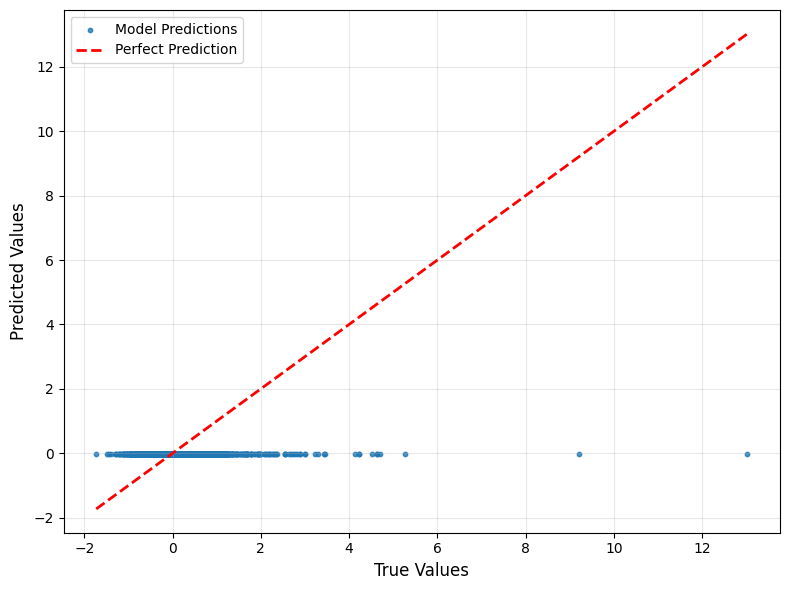

In [43]:
# Create scatter plot only
plt.figure(figsize=(8, 6))

plt.scatter(true_array, preds_array, alpha=0.8, s=10, label="Model Predictions")
plt.plot([true_array.min(), true_array.max()], 
         [true_array.min(), true_array.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
# plt.title('Predicted vs True Values on Test Set', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

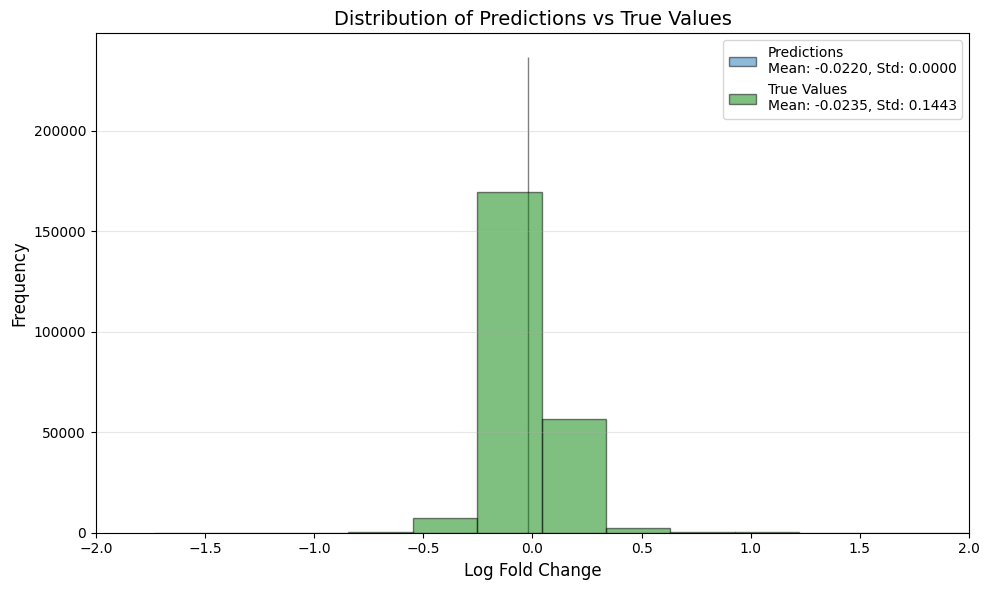


⚠️  WARNING: Model is predicting nearly constant values!
    This indicates the model has collapsed to predicting the mean.


In [ ]:
# Create overlapping histogram visualization
plt.figure(figsize=(10, 6))

# Plot both histograms on the same axes
plt.hist(preds_array, bins=50, alpha=0.5, edgecolor='black', label=f'Predictions\nMean: {preds_array.mean():.4f}, Std: {preds_array.std():.4f}')
plt.hist(true_array, bins=50, alpha=0.5, color='green', edgecolor='black', label=f'True Values\nMean: {true_array.mean():.4f}, Std: {true_array.std():.4f}')

plt.xlim(-2, 2)
plt.xlabel('Log Fold Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Predicted vs True Expression Changes', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Check if predictions are nearly constant (variance near zero)
if preds_array.std() < 0.01:
    print("\n⚠️  WARNING: Model is predicting nearly constant values!")
    print("    This indicates the model has collapsed to predicting the mean.")

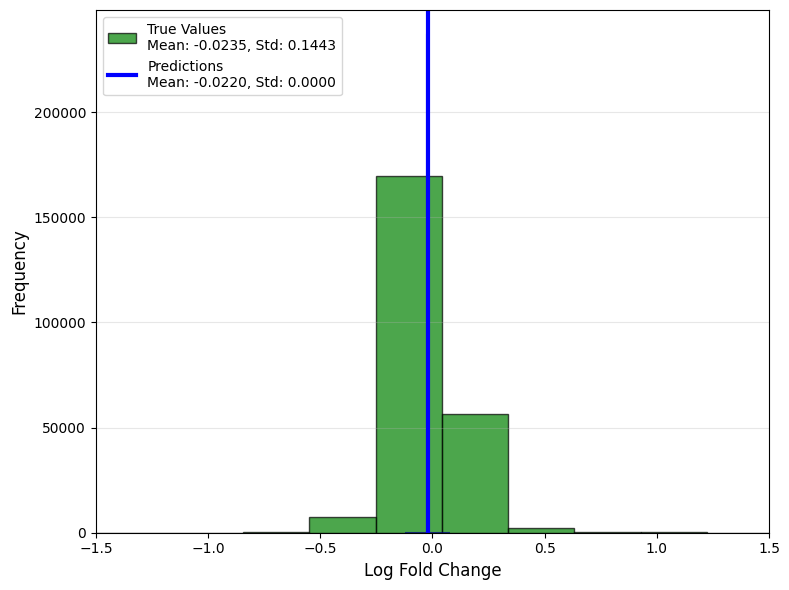


⚠️  WARNING: Model is predicting nearly constant values!
    This indicates the model has collapsed to predicting the mean.


In [42]:
# Create overlapping histogram visualization with better highlighting of narrow predictions
plt.figure(figsize=(8, 6))

# Plot true values first (wider distribution)
plt.hist(true_array, bins=50, alpha=0.7, color='green', edgecolor='black', 
         label=f'True Values\nMean: {true_array.mean():.4f}, Std: {true_array.std():.4f}')

# Plot predictions with a vertical line and marker since distribution is very narrow
plt.axvline(preds_array.mean(), color='blue', linewidth=3, linestyle='-', 
            label=f'Predictions\nMean: {preds_array.mean():.4f}, Std: {preds_array.std():.4f}')

# Add a small histogram for predictions with tight bins around the mean
pred_range = max(0.1, 3 * preds_array.std())  # Use 3 std or 0.1, whichever is larger
pred_bins = np.linspace(preds_array.mean() - pred_range, 
                        preds_array.mean() + pred_range, 30)
plt.hist(preds_array, bins=pred_bins, alpha=0.7, color='blue', edgecolor='darkblue', linewidth=1.5)

plt.xlim(-1.5, 1.5)
plt.xlabel('Log Fold Change', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# plt.title('Distribution of Predicted vs True Expression Changes', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Check if predictions are nearly constant (variance near zero)
if preds_array.std() < 0.01:
    print("\n⚠️  WARNING: Model is predicting nearly constant values!")
    print("    This indicates the model has collapsed to predicting the mean.")